# CÀI THƯ VIỆN

In [69]:

# @title Install Dependencies
!pip install -q datasets evaluate sentence-transformers faiss-cpu langchain langchain_community scikit-learn transformers


In [70]:
pip install -U langchain-huggingface


In [71]:
from huggingface_hub import notebook_login

notebook_login()

# Import thư viện

In [72]:
import os
import time
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import load_dataset, Dataset
from evaluate import load as load_metric
from scipy.stats import f_oneway
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# LLM components
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from sentence_transformers import SentenceTransformer
# Import RunnableSequence from langchain_core.runnables
from langchain_core.runnables import RunnableSequence
from langchain.vectorstores import FAISS
from sentence_transformers import SentenceTransformer


# Cấu hình

In [73]:
MAX_SAMPLES = 20  # Reduced to run faster on Colab Free
MODEL_ID = "google/flan-t5-base"  # Small but still capable
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # Efficient embedding model
RANDOM_SEED = 42

# Set seeds for reproducibility
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# LOAD BENCHMARKS

In [74]:
def load_qa_datasets(max_samples=MAX_SAMPLES):
    """Load and preprocess benchmark datasets"""
    print("Loading evaluation datasets...")

    # Function to extract answers from different dataset formats
    def extract_answers(example, dataset_name):
        if dataset_name == 'hotpotqa':
            return {'text': [example['answer']], 'answer_start': [0]}
        elif dataset_name == 'squad':
            return example['answers']
        elif dataset_name == 'naturalquestions':
            # For NQ, take the first annotated short answer if available
            short_answers = example['annotations']['short_answers'][0]
            if short_answers and len(short_answers['text']) > 0:
                return {'text': [short_answers['text'][0]], 'answer_start': [short_answers['start'][0]]}
            return {'text': [''], 'answer_start': [0]}
        elif dataset_name == 'triviaqa':
            # Extract first answer from TriviaQA
            return {'text': [example['answer']['value']], 'answer_start': [0]}
        return {'text': [''], 'answer_start': [0]}

    # Function to extract context from different dataset formats
    def extract_context(example, dataset_name):
        if dataset_name == 'hotpotqa':
            # Concatenate supporting facts
            contexts = []
            for title, sents in example['context']:
                context_text = f"{title}: {' '.join(sents)}"
                contexts.append(context_text)
            return " ".join(contexts)
        elif dataset_name == 'squad':
            return example['context']
        elif dataset_name == 'naturalquestions':
            # Use document text as context
            return example['document']['text']
        elif dataset_name == 'triviaqa':
            # Use entity pages if available, otherwise empty context
            if 'entity_pages' in example and example['entity_pages']:
                return " ".join([page['wiki_context'] for page in example['entity_pages']])
            return ""
        return ""

    # Initialize datasets dictionary
    benchmarks = {}

    # Try loading HotpotQA
    try:
        hotpotqa = load_dataset('hotpot_qa', 'fullwiki', split=f'train[:{max_samples}]', download_mode="force_redownload")
        benchmarks['hotpotqa'] = Dataset.from_dict({
            'id': [f"hotpot_{i}" for i in range(len(hotpotqa))],
            'question': hotpotqa['question'],
            'context': [extract_context(ex, 'hotpotqa') for ex in hotpotqa],
            'answers': [extract_answers(ex, 'hotpotqa') for ex in hotpotqa],
            'difficulty': ['hard' if ex['level'] == 'hard' else 'medium' for ex in hotpotqa]
        })
        print(f"  - Successfully loaded HotpotQA: {len(benchmarks['hotpotqa'])} samples")
    except Exception as e:
        print(f"Error loading HotpotQA: {e}")

    # Try loading SQuAD 2.0 - fix the split pattern
    try:
        # Thay thế split pattern với một cái đơn giản hơn
        squad = load_dataset('squad_v2', split='train', download_mode="force_redownload")
        if max_samples < len(squad):
            squad = squad.select(range(max_samples))

        benchmarks['squad'] = Dataset.from_dict({
            'id': squad['id'],
            'question': squad['question'],
            'context': squad['context'],
            'answers': squad['answers'],
            'difficulty': ['easy'] * len(squad)  # Most SQuAD questions are relatively straightforward
        })
        print(f"  - Successfully loaded SQuAD: {len(benchmarks['squad'])} samples")
    except Exception as e:
        print(f"Error loading SQuAD: {e}")

    # Try loading TriviaQA - fix the split pattern
    try:
        # Thay thế split pattern với một cái đơn giản hơn
        triviaqa = load_dataset('trivia_qa', 'unfiltered', split='train', download_mode="force_redownload")
        if max_samples < len(triviaqa):
            triviaqa = triviaqa.select(range(max_samples))

        benchmarks['triviaqa'] = Dataset.from_dict({
            'id': [f"trivia_{i}" for i in range(len(triviaqa))],
            'question': triviaqa['question'],
            'context': [extract_context(ex, 'triviaqa') for ex in triviaqa],
            'answers': [extract_answers(ex, 'triviaqa') for ex in triviaqa],
            'difficulty': ['medium'] * len(triviaqa)  # Default to medium difficulty
        })
        print(f"  - Successfully loaded TriviaQA: {len(benchmarks['triviaqa'])} samples")
    except Exception as e:
        print(f"Error loading TriviaQA: {e}")

    # Try loading Natural Questions - fix the split pattern
    try:
        # Thay thế split pattern với một cái đơn giản hơn
        nq = load_dataset('natural_questions', split='train', download_mode="force_redownload")
        if max_samples//2 < len(nq):
            nq = nq.select(range(max_samples//2))  # Smaller due to size

        nq_data = {
            'id': [f"nq_{i}" for i in range(len(nq))],
            'question': [ex['question']['text'] for ex in nq],
            'context': [extract_context(ex, 'naturalquestions') for ex in nq],
            'answers': [extract_answers(ex, 'naturalquestions') for ex in nq],
            'difficulty': ['medium'] * len(nq)  # Default to medium difficulty
        }
        benchmarks['naturalquestions'] = Dataset.from_dict(nq_data)
        print(f"  - Successfully loaded Natural Questions: {len(benchmarks['naturalquestions'])} samples")
    except Exception as e:
        print(f"Error loading Natural Questions: {e}")

    # Create custom Wikipedia dataset
    topics = ["Bitcoin", "Artificial Intelligence", "Quantum Computing",
              "Climate Change", "Machine Learning"]

    custom_data = []
    for topic in topics:
        # Create variations of questions for each topic
        for i in range(max_samples // len(topics)):
            question_types = [
                f"What is {topic}?",
                f"Explain the main concepts of {topic}.",
                f"Why is {topic} important?",
                f"How does {topic} work?",
                f"What are the applications of {topic}?"
            ]
            question = question_types[i % len(question_types)]

            # Simulated context (in a real scenario, this would come from Wikipedia)
            context = f"This is a simulated context about {topic}. {topic} is an important concept in modern technology and science."

            custom_data.append({
                'id': f"custom_{topic}_{i}",
                'question': question,
                'context': context,
                'answers': {'text': [topic], 'answer_start': [context.find(topic)]},
                'difficulty': random.choice(['easy', 'medium', 'hard'])
            })

    benchmarks['custom'] = Dataset.from_list(custom_data)
    print(f"  - Created custom dataset: {len(benchmarks['custom'])} samples")

    # Print summary
    print(f"Loaded datasets: {', '.join(benchmarks.keys())}")
    for name, dataset in benchmarks.items():
        print(f"  - {name}: {len(dataset)} samples")

    return benchmarks

# EMBEDDING INDEX

In [75]:
def build_vector_index(text_chunks):
    """Build FAISS index from text chunks using SentenceTransformers"""
    print("Building vector index...")

    # Use a lightweight embedding model
    embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

    # Create FAISS index
    faiss_index = FAISS.from_texts(text_chunks, embedding=embedding_model)

    return faiss_index

# LOAD MODELS

In [76]:
def load_language_model():
    """Load and configure the language model"""
    print(f"Loading language model: {MODEL_ID}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

    # Create pipeline
    hf_pipe = pipeline(
        'text2text-generation',
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=64,
        do_sample=False
    )

    # Create LangChain LLM
    llm = HuggingFacePipeline(pipeline=hf_pipe)

    return llm, tokenizer, model

# MODEL SIMPLE RAG BASELINE

In [77]:
class SimpleRAG:
    """Simple RAG baseline using TF-IDF for retrieval"""

    def __init__(self, documents):
        self.documents = documents
        self.vectorizer = TfidfVectorizer(stop_words='english')
        self.doc_vectors = self.vectorizer.fit_transform(documents)

    def retrieve(self, query, k=3):
        """Retrieve top-k documents using TF-IDF similarity"""
        query_vector = self.vectorizer.transform([query])
        similarities = cosine_similarity(query_vector, self.doc_vectors).flatten()
        top_indices = similarities.argsort()[-k:][::-1]
        return [self.documents[i] for i in top_indices]

# THỰC HIỆN CÁC AGENT

In [78]:
def setup_agents(llm, faiss_index, retriever):
    """Set up different agent architectures"""

    # Single Agent - direct QA
    single_prompt = PromptTemplate(
        input_variables=['question', 'context'],
        template="Answer the question based on the given context.\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer:"
    )
    single_chain = single_prompt | llm

    def single_agent(question, context):
        """Simple agent that directly answers based on provided context"""
        try:
            return single_chain.invoke({'question': question, 'context': context}).strip()
        except Exception as e:
            print(f"Error in single agent: {e}")
            return ""

    # Corrective Agent - evaluates answers and refines if needed
    eval_prompt = PromptTemplate(
        input_variables=['context', 'question', 'answer'],
        template="Based on the context and question, evaluate if the answer is correct.\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer: {answer}\n\nIs this answer correct? Respond with Yes or No:"
    )
    eval_chain = eval_prompt | llm

    refine_prompt = PromptTemplate(
        input_variables=['question', 'answer'],
        template="The original question was: {question}\n\nThe suggested answer: {answer} might not be accurate.\n\nPlease rewrite the question to better capture what information is needed:"
    )
    refine_chain = refine_prompt | llm

    def corrective_agent(question, context):
        """Agent that evaluates its own answers and refines them if needed"""
        try:
            # First attempt
            answer1 = single_agent(question, context)

            # Self-evaluation
            verdict = eval_chain.invoke({'context': context, 'question': question, 'answer': answer1}).lower()

            # If not confident, refine and try again
            if 'no' in verdict:
                refined_question = refine_chain.invoke({'question': question, 'answer': answer1})
                return single_agent(refined_question, context)

            return answer1
        except Exception as e:
            print(f"Error in corrective agent: {e}")
            return ""

    # Adaptive Agent - adjusts retrieval based on question complexity
    classify_prompt = PromptTemplate(
        input_variables=['question'],
        template="Classify the complexity of this question as easy, medium, or hard:\n\n{question}\n\nComplexity:"
    )
    classify_chain = classify_prompt | llm

    def adaptive_agent(question, orig_context):
        """Agent that adapts retrieval strategy based on question complexity"""
        try:
            # Classify question complexity
            complexity = classify_chain.invoke({'question': question}).strip().lower()

            # Determine number of documents to retrieve based on complexity
            k = {'easy': 1, 'medium': 3, 'hard': 5}.get(complexity, 3)

            # Retrieve documents
            if faiss_index:
                docs = faiss_index.similarity_search(question, k=k)
                new_context = " ".join([d.page_content for d in docs])
                # Combine retrieved context with original if available
                context = new_context + " " + orig_context if orig_context else new_context
            else:
                context = orig_context

            # Generate answer
            return single_agent(question, context)
        except Exception as e:
            print(f"Error in adaptive agent: {e}")
            return ""

    # RAG Baseline using TF-IDF
    def rag_baseline(question, orig_context=None):
        """Simple RAG baseline"""
        try:
            # Retrieve documents
            documents = retriever.retrieve(question, k=3)
            context = " ".join(documents)

            # Generate answer
            return single_agent(question, context)
        except Exception as e:
            print(f"Error in RAG baseline: {e}")
            return ""

    return {
        'single': single_agent,
        'corrective': corrective_agent,
        'adaptive': adaptive_agent,
        'rag': rag_baseline
    }

# EVALUATION FUNCTIONS

In [83]:
def evaluate_agents(agents, benchmarks, metric):
    """Evaluate all agents on all benchmarks"""
    records = []

    # Create overall progress bar
    total_evals = sum(len(ds) for ds in benchmarks.values()) * len(agents)

    print(f"Starting evaluation: {total_evals} total evaluations")

    # Loop through datasets
    for name, ds in benchmarks.items():
        print(f"\nEvaluating on {name} dataset ({len(ds)} samples)")

        # Loop through samples
        for i, sample in enumerate(ds):
            if i % 5 == 0:
                print(f"  Progress: {i}/{len(ds)} samples")

            # Extract data
            q_id = sample.get('id', f"{name}_{i}")
            question = sample['question']
            context = sample['context']
            gold_answers = sample['answers']['text']
            difficulty = sample.get('difficulty', 'medium')

            # Clean gold answers - keep only the first non-empty answer
            gold_answer = next((a for a in gold_answers if a and a.strip()), "")

            # Loop through agents
            for agent_name, agent_fn in agents.items():
                # Measure time and memory
                t0 = time.time()
                mem_before = psutil.Process().memory_info().rss / (1024**2)

                # Generate answer
                if agent_name == 'rag':
                    answer = agent_fn(question)
                else:
                    answer = agent_fn(question, context)

                # Measure resources
                latency = time.time() - t0
                mem_after = psutil.Process().memory_info().rss / (1024**2)
                mem_usage = mem_after - mem_before

                # Calculate metrics
                if gold_answer:
                    # Use the evaluate metric for official scores
                    result = metric.compute(
                        predictions=[{'id': q_id, 'prediction_text': answer}],
                        references=[{'id': q_id, 'answers': {'text': [gold_answer], 'answer_start': [0]}}]
                    )
                    exact_match = result['exact_match']
                    f1_score = result['f1']
                else:
                    # If no gold answer, set metrics to 0
                    exact_match = 0
                    f1_score = 0

                # Store results
                records.append({
                    'dataset': name,
                    'question_id': q_id,
                    'question': question,
                    'context': context[:100] + "..." if len(context) > 100 else context,
                    'gold_answer': gold_answer,
                    'predicted_answer': answer,
                    'agent': agent_name,
                    'difficulty': difficulty,
                    'exact_match': exact_match,
                    'f1': f1_score,
                    'latency': latency,
                    'memory_mb': mem_usage
                })

    # Convert to DataFrame
    results_df = pd.DataFrame(records)
    return results_df


# KẾT QUẢ PHÂN TÍCH

In [84]:
def analyze_results(results_df):
    """Generate analysis and visualizations from evaluation results"""
    import matplotlib.pyplot as plt
    from scipy.stats import f_oneway
    import seaborn as sns

    print("\n=== EVALUATION RESULTS ===\n")

    # Set style for better visualization
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("Set2")

    # Overall performance
    summary = results_df.groupby('agent').agg(
        Accuracy=('exact_match', 'mean'),
        F1_Score=('f1', 'mean'),
        Avg_Latency_sec=('latency', 'mean'),
        Avg_Memory_MB=('memory_mb', 'mean')
    ).round(3)

    print("Overall Performance:")
    print(summary)

    # Performance by dataset
    dataset_perf = results_df.groupby(['agent', 'dataset'])[['exact_match', 'f1']].mean().unstack()
    print("\nPerformance by Dataset (Accuracy):")
    print(dataset_perf['exact_match'].round(3))

    # Multi-hop accuracy (HotpotQA)
    if 'hotpotqa' in results_df['dataset'].unique():
        multihop = results_df[results_df.dataset=='hotpotqa'].groupby('agent')['exact_match'].mean().rename('MultiHop_Accuracy')
        print("\nMulti-hop Question Accuracy (HotpotQA):")
        print(multihop.round(3))
    else:
        print("\nMulti-hop Question Accuracy (HotpotQA):")
        print("No HotpotQA data available")

    # Show performance by difficulty
    print("\nPerformance by Question Difficulty:")
    diff_perf = results_df.pivot_table(
        index='agent',
        columns='difficulty',
        values='exact_match',
        aggfunc='mean'
    ).fillna(0).round(3)
    print(diff_perf)

    # Adaptability (std dev across difficulty levels)
    adapt_data = results_df.pivot_table(
        index=['agent', 'difficulty'],
        values='exact_match',
        aggfunc='mean'
    ).reset_index()
    adaptability = adapt_data.pivot_table(
        index='agent',
        columns='difficulty',
        values='exact_match'
    ).fillna(0)
    adaptability['std'] = adaptability.std(axis=1)
    adaptability['adaptability_score'] = 1 - adaptability['std']  # Lower std = higher adaptability

    print("\nAdaptability Scores (higher is better):")
    print(adaptability['adaptability_score'].round(3))

    # Statistical significance (ANOVA)
    agent_groups = [results_df[results_df.agent==a]['exact_match'] for a in results_df['agent'].unique()]
    f_stat, p_val = f_oneway(*agent_groups)
    print(f"\nANOVA Test for Statistical Significance:")
    print(f"F-statistic: {f_stat:.3f}, p-value: {p_val:.3f}")
    if p_val < 0.05:
        print("The performance differences between agents are statistically significant (p < 0.05)")
    else:
        print("The performance differences between agents are NOT statistically significant (p >= 0.05)")

    # Generate visualizations with improved appearance
    plt.figure(figsize=(16, 12))  # Larger figure size

    # Accuracy chart
    plt.subplot(2, 2, 1)
    ax1 = summary['Accuracy'].plot(kind='bar', color=sns.color_palette("Set2")[0],
                                  edgecolor='black', linewidth=1.2)
    plt.title('Accuracy by Agent', fontsize=14, fontweight='bold')
    plt.xlabel('Agent Type', fontsize=12)
    plt.ylabel('Accuracy (Exact Match)', fontsize=12)
    plt.ylim(0, min(1.0, max(summary['Accuracy'].max() * 1.2, 0.1)))
    plt.xticks(rotation=30, ha='right')

    # Add value labels on top of bars
    for i, v in enumerate(summary['Accuracy']):
        ax1.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

    # F1 chart
    plt.subplot(2, 2, 2)
    ax2 = summary['F1_Score'].plot(kind='bar', color=sns.color_palette("Set2")[1],
                                  edgecolor='black', linewidth=1.2)
    plt.title('F1 Score by Agent', fontsize=14, fontweight='bold')
    plt.xlabel('Agent Type', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.ylim(0, min(1.0, max(summary['F1_Score'].max() * 1.2, 0.1)))
    plt.xticks(rotation=30, ha='right')

    # Add value labels on top of bars
    for i, v in enumerate(summary['F1_Score']):
        ax2.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

    # Latency chart
    plt.subplot(2, 2, 3)
    ax3 = summary['Avg_Latency_sec'].plot(kind='bar', color=sns.color_palette("Set2")[2],
                                         edgecolor='black', linewidth=1.2)
    plt.title('Average Latency by Agent', fontsize=14, fontweight='bold')
    plt.xlabel('Agent Type', fontsize=12)
    plt.ylabel('Latency (seconds)', fontsize=12)
    plt.xticks(rotation=30, ha='right')

    # Add value labels on top of bars
    for i, v in enumerate(summary['Avg_Latency_sec']):
        ax3.text(i, v + (summary['Avg_Latency_sec'].max() * 0.05), f"{v:.2f}s",
                ha='center', fontsize=10)

    # Performance by dataset or difficulty level
    plt.subplot(2, 2, 4)
    if len(results_df['dataset'].unique()) > 1 and not dataset_perf['exact_match'].empty:
        ax4 = dataset_perf['exact_match'].plot(kind='bar', edgecolor='black', linewidth=1.2)
        plt.title('Performance by Dataset', fontsize=14, fontweight='bold')
        plt.xlabel('Agent Type', fontsize=12)
        plt.ylabel('Accuracy (Exact Match)', fontsize=12)
        plt.ylim(0, 1)
        plt.legend(title='Dataset', title_fontsize=12, fontsize=10, loc='best')
        plt.xticks(rotation=30, ha='right')
    else:
        # Alternative plot if only one dataset
        ax4 = diff_perf.plot(kind='bar', edgecolor='black', linewidth=1.2)
        plt.title('Performance by Difficulty', fontsize=14, fontweight='bold')
        plt.xlabel('Agent Type', fontsize=12)
        plt.ylabel('Accuracy (Exact Match)', fontsize=12)
        plt.ylim(0, 1)
        plt.legend(title='Difficulty', title_fontsize=12, fontsize=10, loc='best')
        plt.xticks(rotation=30, ha='right')

    # Add more space between subplots
    plt.tight_layout(pad=4.0)

    # Create an additional visualization for adaptability
    plt.figure(figsize=(10, 6))
    ax5 = adaptability['adaptability_score'].plot(kind='bar',
                                                color=sns.color_palette("Set2")[3],
                                                edgecolor='black', linewidth=1.2)
    plt.title('Agent Adaptability Scores', fontsize=14, fontweight='bold')
    plt.xlabel('Agent Type', fontsize=12)
    plt.ylabel('Adaptability Score (higher is better)', fontsize=12)
    plt.ylim(0, min(1.0, adaptability['adaptability_score'].max() * 1.2))
    plt.xticks(rotation=30, ha='right')

    # Add value labels on top of bars
    for i, v in enumerate(adaptability['adaptability_score']):
        ax5.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

    plt.tight_layout()

    # Save visualizations
    try:
        plt.figure(1)
        plt.savefig('agent_performance.png', dpi=300, bbox_inches='tight')
        plt.figure(2)
        plt.savefig('agent_adaptability.png', dpi=300, bbox_inches='tight')
        print("\nVisualizations saved to 'agent_performance.png' and 'agent_adaptability.png'")
    except Exception as e:
        print(f"\nError saving visualization: {e}")

    return summary, adaptability

# MAIN THỰC THI CÁC CHỨC NĂNG

Starting RAG Agents Evaluation Pipeline
Loading evaluation datasets...


Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Error loading HotpotQA: Loading a dataset cached in a LocalFileSystem is not supported.


Error loading SQuAD: Invalid pattern: '**' can only be an entire path component


Error loading TriviaQA: Invalid pattern: '**' can only be an entire path component


Error loading Natural Questions: Invalid pattern: '**' can only be an entire path component
  - Created custom dataset: 20 samples
Loaded datasets: custom
  - custom: 20 samples
Building vector index...
Loading language model: google/flan-t5-base


Device set to use cuda:0


Starting evaluation: 80 total evaluations

Evaluating on custom dataset (20 samples)
  Progress: 0/20 samples
  Progress: 5/20 samples
  Progress: 10/20 samples
  Progress: 15/20 samples

=== EVALUATION RESULTS ===

Overall Performance:
            Accuracy  F1_Score  Avg_Latency_sec  Avg_Memory_MB
agent                                                         
adaptive         0.0    13.191            0.325            0.0
corrective       5.0    14.778            0.274            0.0
rag              0.0    11.763            0.292            0.0
single           5.0    14.778            0.233            0.0

Performance by Dataset (Accuracy):
dataset     custom
agent             
adaptive       0.0
corrective     5.0
rag            0.0
single         5.0

Multi-hop Question Accuracy (HotpotQA):
No HotpotQA data available

Performance by Question Difficulty:
difficulty    easy  hard  medium
agent                           
adaptive     0.000   0.0     0.0
corrective  16.667   0.0     0.

<ipython-input-84-0a9688694af2>:158: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Visualizations saved to 'agent_performance.png' and 'agent_adaptability.png'

Results saved to 'rag_agents_evaluation_results.csv'

Evaluation completed!


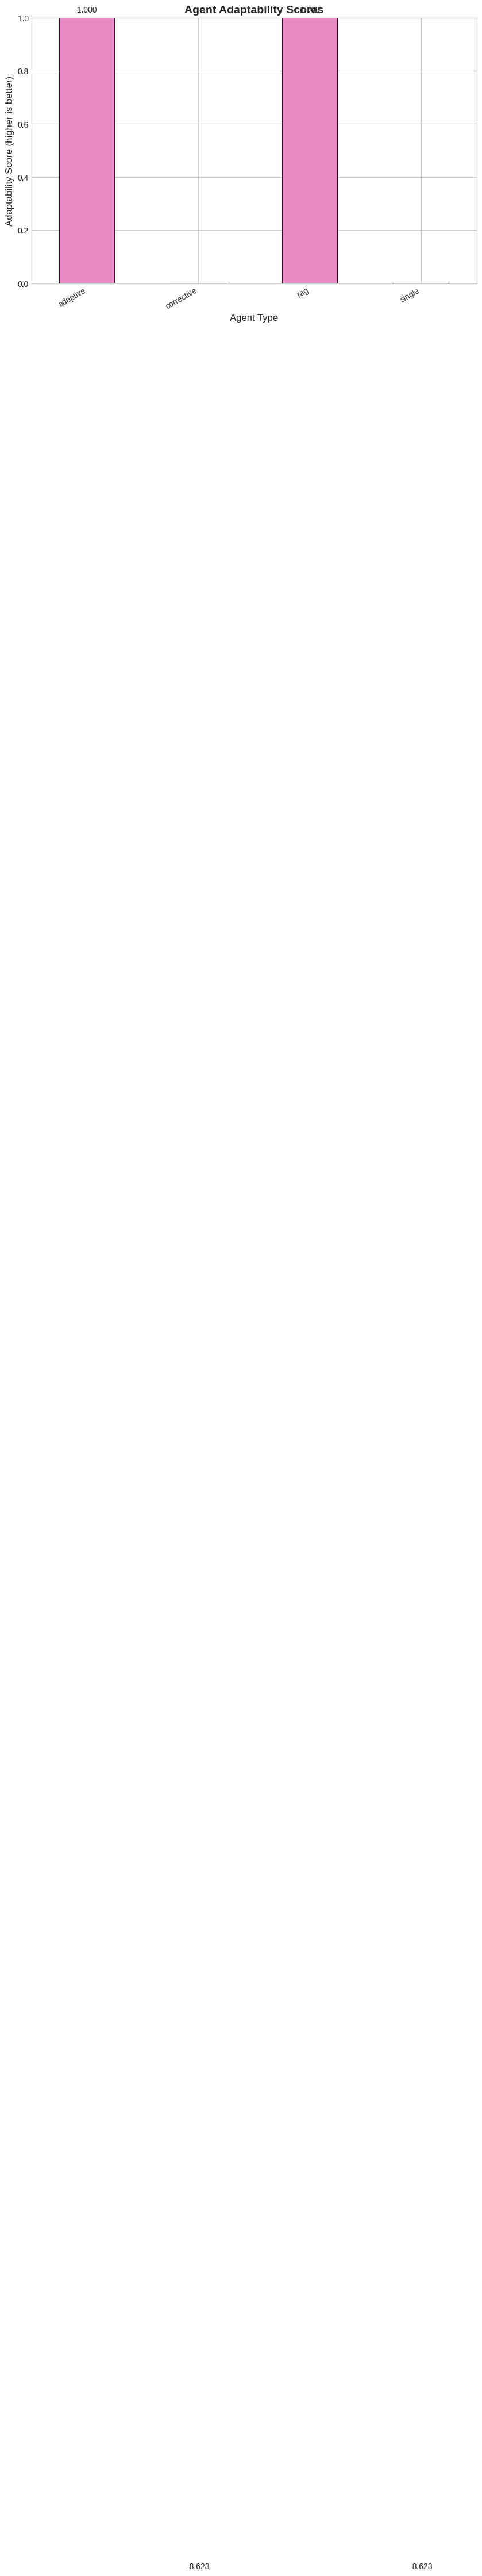

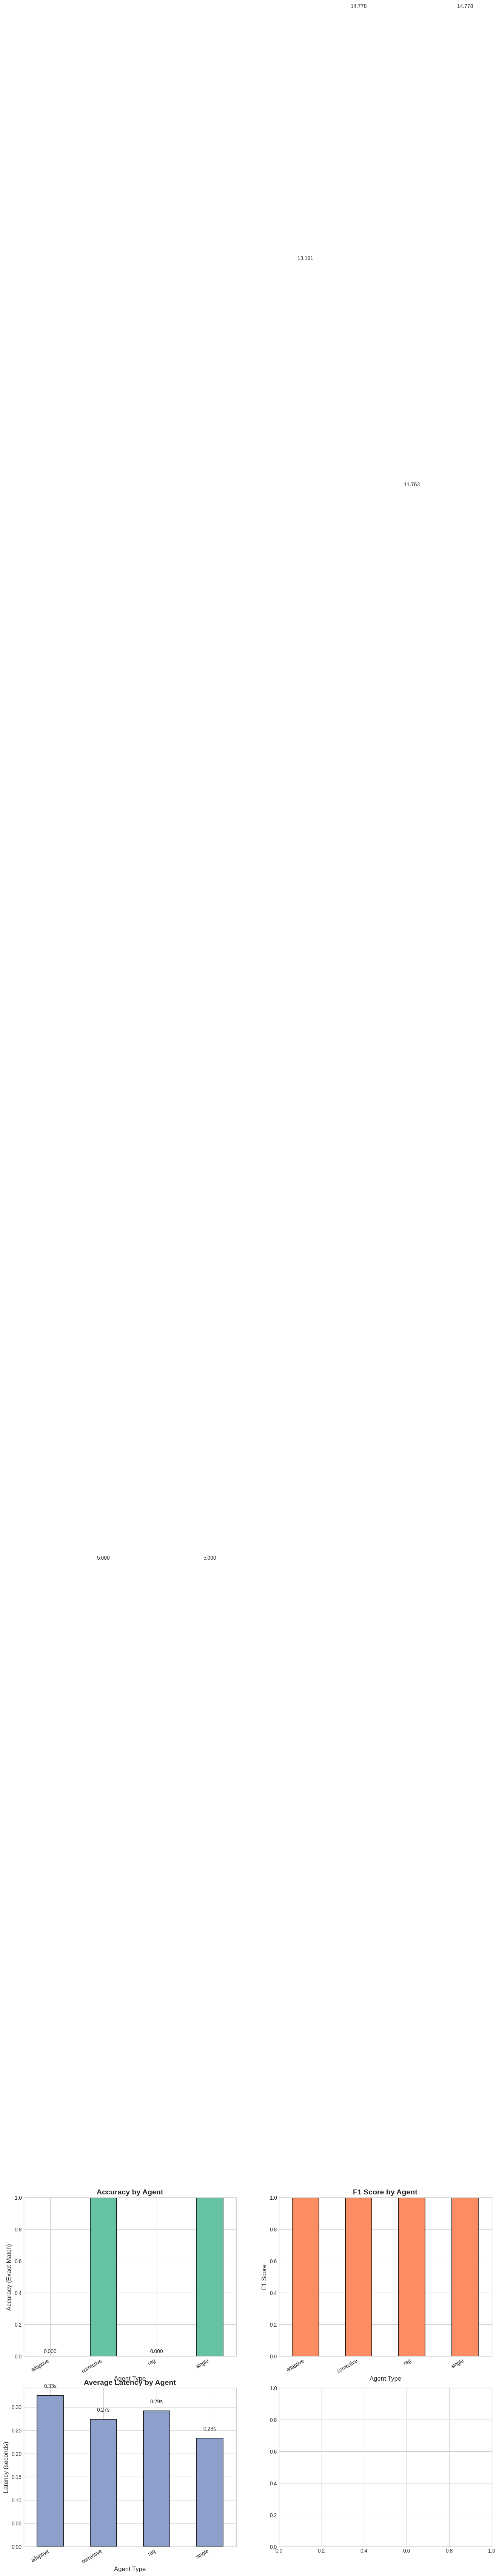

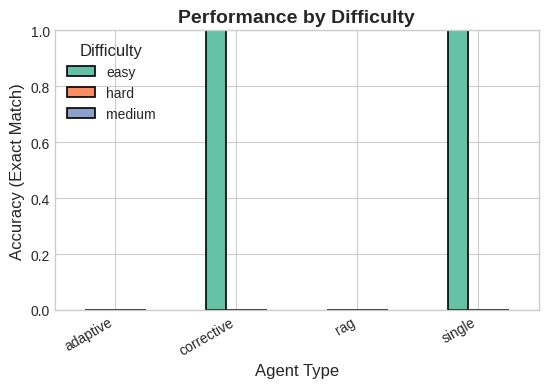

In [85]:
def main():
    """Main execution function"""
    print("Starting RAG Agents Evaluation Pipeline")

    # 1. Load datasets
    benchmarks = load_qa_datasets(max_samples=MAX_SAMPLES)

    # Collect all contexts for indexing
    all_contexts = []
    for dataset in benchmarks.values():
        all_contexts.extend(dataset['context'])

    # Split long contexts into chunks for better retrieval
    context_chunks = []
    for ctx in all_contexts:
        if len(ctx) > 500:
            # Simple chunking by splitting on periods
            sentences = ctx.split('. ')
            chunk_size = 3  # Number of sentences per chunk
            for i in range(0, len(sentences), chunk_size):
                chunk = '. '.join(sentences[i:i+chunk_size])
                if chunk:
                    context_chunks.append(chunk)
        else:
            context_chunks.append(ctx)

    # 2. Build vector index
    try:
        faiss_index = build_vector_index(context_chunks)
    except Exception as e:
        print(f"Error building vector index: {e}")
        faiss_index = None

    # Simple retriever for baseline RAG
    simple_retriever = SimpleRAG(context_chunks)

    # 3. Load language model
    llm, tokenizer, model = load_language_model()

    # 4. Setup agents
    agents = setup_agents(llm, faiss_index, simple_retriever)

    # 5. Load evaluation metric
    squad_metric = load_metric('squad')

    # 6. Run evaluation
    results_df = evaluate_agents(agents, benchmarks, squad_metric)

    # 7. Analyze and visualize results
    summary, adaptability = analyze_results(results_df)

    # 8. Save results
    results_df.to_csv('rag_agents_evaluation_results.csv', index=False)
    print("\nResults saved to 'rag_agents_evaluation_results.csv'")

    print("\nEvaluation completed!")
    return results_df, summary, adaptability

# Execute if run as script
if __name__ == "__main__":
    main()